In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pandas as pd

import torchvision

In [3]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV

In [4]:
def rmse(model, x, y):
    y_pred = model.predict(x)
    mse = mean_squared_error(y_pred, y)
    rmse = np.sqrt(mse)
    return(rmse)

In [5]:
import data_pipeline as dp
from data_pipeline.data_preprocessor import PreProcessor as PP
# load train set, test set

pp = PP("total_data.csv")

x_train, y_train, x_test, y_test = pp.process()

pp_d = PP("final_data.csv")
# for conti / discrete comparing
x_train_d, y_train_d, x_test_d, y_test_d = pp_d.process()

y_train

8678    -1.650959
15667   -0.113631
12154   -0.805595
13160   -0.395112
11375   -0.436952
           ...   
13005   -0.445733
6342     1.567956
20748    0.535097
19574    0.431213
21388    0.394619
Name: latency, Length: 17014, dtype: float64

In [6]:
# -----------------------------------------------------------------

In [7]:
# kernel Ridge regression

# KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5) #kernel = 'rbf' , 'sigmoid' 

In [8]:
# Gradient Boosting Regression

GBoost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1,
                                   max_depth=3, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [9]:
# LGB Regressor

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=500,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"


In [11]:
# XGBoost Algorithm (without GridSearch)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4, gamma=0.05, 
                             learning_rate=0.12, max_depth=4, 
                             min_child_weight=1.5, n_estimators=500,
                             reg_alpha=0.5, reg_lambda=0.7, tree_method="gpu_hist",
                             subsample=0.5, random_state =3, nthread = -1)

In [12]:
# Random Forest Regressor with GridSearch


regr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=150, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

#grid_search.best_estimator_

In [13]:
# -----------------------------------------------------

In [14]:
model_xgb.fit(x_train, y_train)
model_lgb.fit(x_train, y_train)
GBoost.fit(x_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='huber',
                          max_depth=3, max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=5, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
# Gradient Boosting score
score = rmse(GBoost, x_train, y_train)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1433 (0.0000)



In [16]:
# Light GBM score
score = rmse(model_lgb, x_train, y_train)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1733 (0.0000)



In [17]:
# XGBoost score
score = rmse(model_xgb, x_train, y_train)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1100 (0.0000)



In [18]:
from joblib import load
def inverse_latency(X):
    robust, quantile = load("robust.pkl"), load("quantile.pkl")
    if isinstance(X, pd.Series):
        X = X.values.reshape(-1, 1)
    else:
        X = X.reshape(-1, 1)
    return robust.inverse_transform(quantile.inverse_transform(X)).reshape(-1)

In [19]:
#define a rmsle evaluation function

# def rmsle(y, y_pred): 
#    return np.sqrt(mean_squared_error(y, y_pred))

def rmse_with_inverse(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_test, y_pred = inverse_latency(y_test), inverse_latency(y_pred)
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [20]:
print("Gradient Boosting rmse: {}".format(rmse_with_inverse(GBoost, x_test, y_test)))
print("LGBM rmse : {}".format(rmse_with_inverse(model_lgb, x_test, y_test)))
print("Xgboost rmse : {}".format(rmse_with_inverse(model_xgb, x_test, y_test)))

Gradient Boosting rmse: 26478.48127099066
LGBM rmse : 19893.283353652718
Xgboost rmse : 20978.091460264524


In [21]:
print("Gradient Boosting rmse: {}".format(rmse_with_inverse(GBoost, x_test_d, y_test_d)))
print("LGBM rmse : {}".format(rmse_with_inverse(model_lgb, x_test_d, y_test_d)))
print("Xgboost rmse : {}".format(rmse_with_inverse(model_xgb, x_test_d, y_test_d)))

Gradient Boosting rmse: 170904.1662900002
LGBM rmse : 170521.9089896444
Xgboost rmse : 174987.57153353348


# XGBoost

In [22]:
# XGBoost score with discrete
score = rmse(model_xgb, x_test_d, y_test_d)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.9540 (0.0000)



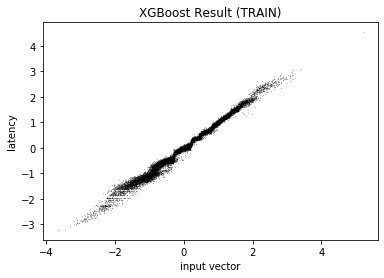

In [23]:
xgb_train_pred = model_xgb.predict(x_train)

plt.scatter(y_train, xgb_train_pred, s=0.01, color='black')
plt.xlabel('input vector')
plt.ylabel('latency')
plt.title('XGBoost Result (TRAIN)')
plt.show()

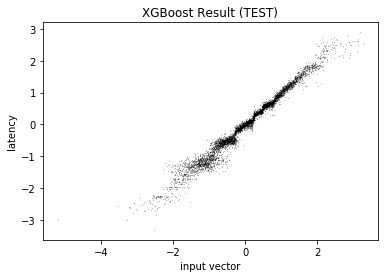

In [24]:
xgb_pred = model_xgb.predict(x_test)

#plt.plot(x_test, y_test)
plt.scatter(y_test, xgb_pred, s=0.01, color='black')
plt.xlabel('input vector')
plt.ylabel('latency')
plt.title('XGBoost Result (TEST)')
plt.show()

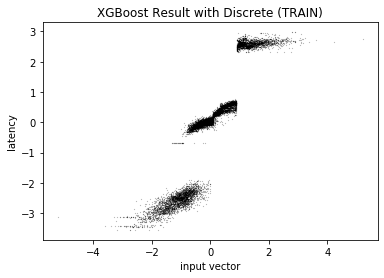

In [25]:
xgb_pred_d = model_xgb.predict(x_train_d)

#plt.plot(x_test, y_test)
plt.scatter(y_train_d, xgb_pred_d, s=0.01, color='black')
plt.xlabel('input vector')
plt.ylabel('latency')
plt.title('XGBoost Result with Discrete (TRAIN)')
plt.show()

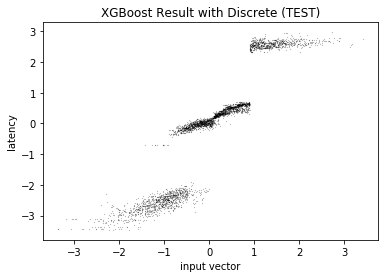

In [26]:
# comparing discrete

xgb_pred_d = model_xgb.predict(x_test_d)

#plt.plot(x_test, y_test)
plt.scatter(y_test_d, xgb_pred_d, s=0.01, color='black')
plt.xlabel('input vector')
plt.ylabel('latency')
plt.title('XGBoost Result with Discrete (TEST)')
plt.show()

In [27]:
print(model_xgb.feature_importances_)

[0.03595888 0.07240119 0.27406302 0.00317613 0.00343299 0.00437488
 0.0024667  0.00162647 0.00236673 0.00184317 0.00214276 0.00209053
 0.00158861 0.01547168 0.00265518 0.00785582 0.00199761 0.00164933
 0.00447662 0.00305904 0.0069564  0.0039011  0.00359039 0.00258863
 0.01250697 0.00510598 0.00168311 0.00304866 0.00129891 0.0028924
 0.00160521 0.00457139 0.00151248 0.00150406 0.00168677 0.0033363
 0.0101225  0.00229128 0.00554731 0.01203869 0.00490135 0.00221747
 0.00242709 0.00357754 0.00163657 0.0014619  0.01567701 0.00190771
 0.00570251 0.00291431 0.00166564 0.00712742 0.00333116 0.00298618
 0.00724399 0.00324233 0.00218219 0.00209022 0.00185329 0.00375889
 0.00287736 0.00147137 0.00433448 0.00191081 0.00291141 0.00466907
 0.00456714 0.00281825 0.00487368 0.00289218 0.00299374 0.00413664
 0.00893629 0.00396339 0.0027     0.00281212 0.00144999 0.00369632
 0.0020424  0.0119282  0.00186958 0.00370952 0.00154157 0.00214448
 0.00799533 0.00184038 0.01264669 0.00648554 0.00186565 0.002897

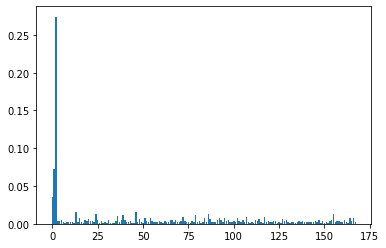

In [28]:
plt.bar(range(len(model_xgb.feature_importances_)), model_xgb.feature_importances_)
plt.show()


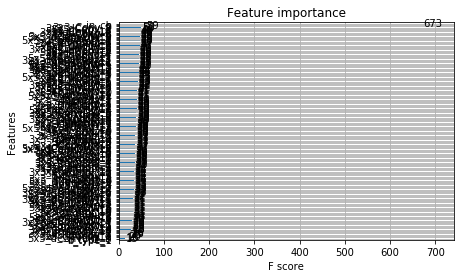

In [29]:
from xgboost import plot_importance
plot_importance(model_xgb)
plt.show()

# Gradient Boost

In [30]:
# Gradient Boosting score
score = rmse(GBoost, x_test_d, y_test_d)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.9326 (0.0000)



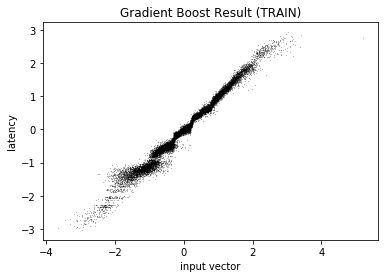

In [31]:
gb_pred = GBoost.predict(x_train)

#plt.plot(x_test, y_test)
plt.scatter(y_train, gb_pred, s=0.01, color='black')
plt.xlabel('input vector')
plt.ylabel('latency')
plt.title('Gradient Boost Result (TRAIN)')
plt.show()

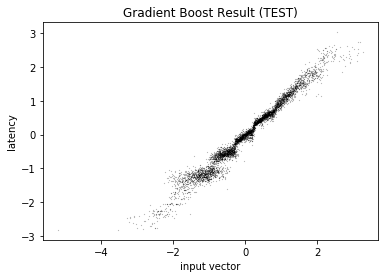

In [32]:
gb_pred = GBoost.predict(x_test)

#plt.plot(x_test, y_test)
plt.scatter(y_test, gb_pred, s=0.01, color='black')
plt.xlabel('input vector')
plt.ylabel('latency')
plt.title('Gradient Boost Result (TEST)')
plt.show()

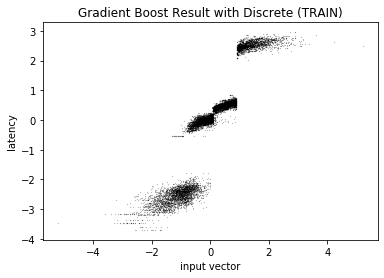

In [33]:
gb_pred = GBoost.predict(x_train_d)

#plt.plot(x_test, y_test)
plt.scatter(y_train_d, gb_pred, s=0.01, color='black')
plt.xlabel('input vector')
plt.ylabel('latency')
plt.title('Gradient Boost Result with Discrete (TRAIN)')
plt.show()

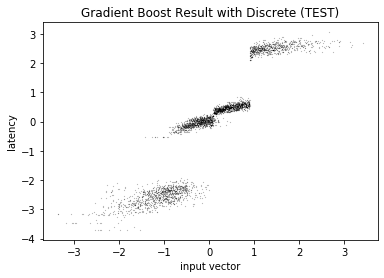

In [34]:
gb_pred = GBoost.predict(x_test_d)

#plt.plot(x_test, y_test)
plt.scatter(y_test_d, gb_pred, s=0.01, color='black')
plt.xlabel('input vector')
plt.ylabel('latency')
plt.title('Gradient Boost Result with Discrete (TEST)')
plt.show()

# Light GBM

In [35]:
# Light GBM score with discrete
score = rmse(model_lgb, x_test_d, y_test_d)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.9282 (0.0000)



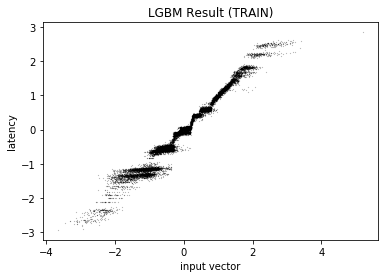

In [36]:
lgb_pred = model_lgb.predict(x_train)

#plt.plot(x_test, y_test)
plt.scatter(y_train, lgb_pred, s=0.01, color='black')
plt.xlabel('input vector')
plt.ylabel('latency')
plt.title('LGBM Result (TRAIN)')
plt.show()

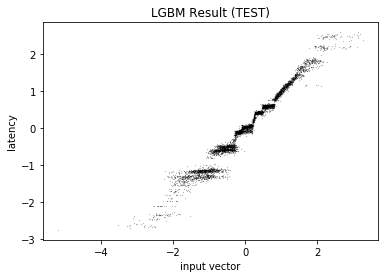

In [37]:
lgb_pred = model_lgb.predict(x_test)

#plt.plot(x_test, y_test)
plt.scatter(y_test, lgb_pred, s=0.01, color='black')
plt.xlabel('input vector')
plt.ylabel('latency')
plt.title('LGBM Result (TEST)')
plt.show()

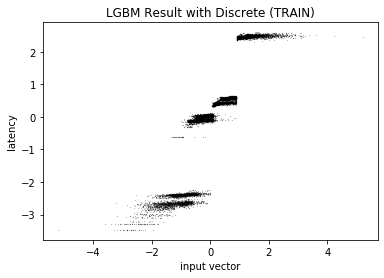

In [38]:
lgb_pred = model_lgb.predict(x_train_d)

#plt.plot(x_test, y_test)
plt.scatter(y_train_d, lgb_pred, s=0.01, color='black')
plt.xlabel('input vector')
plt.ylabel('latency')
plt.title('LGBM Result with Discrete (TRAIN)')
plt.show()

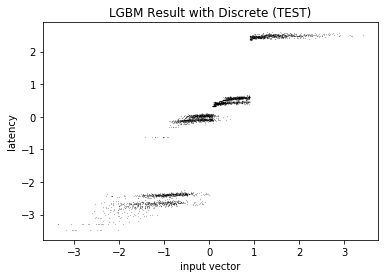

In [39]:
lgb_pred = model_lgb.predict(x_test_d)

#plt.plot(x_test, y_test)
plt.scatter(y_test_d, lgb_pred, s=0.01, color='black')
plt.xlabel('input vector')
plt.ylabel('latency')
plt.title('LGBM Result with Discrete (TEST)')
plt.show()

In [ ]:
# ISSUE : 시사하는 바?